# TODO

**Test the assumptions of Multiple OLS**:
* No multicolieaerity
* Normality of residuals.
* Linear relationship.
* Homoscedasticity.


**Convert timeseries to 5 minute intervals**

**Create forecasting function**
Moving window of training, and testing.

#### Local Imports

In [15]:
from src.data.base_dataset import BaseDataset
from src.data.train_test_generate import generate_rv_data, generate_intraday_data
import src.data.data_generators as dg
from analysis import helpers
from analysis.visualizations import tuftefy

#### External Libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

sns.set()

### Dataset

In [19]:
dataset = BaseDataset("./data/raw/btc_dataset.parquet")

In [20]:
df = dataset.get_dataframe()

In [23]:
df = df.drop(columns="timestamp"); df

,Count,Open,High,Low,Close,Volume
datetime,,,,,,
2018-01-01 00:01:00,229.0,13835.194000,14013.800000,13666.11,13850.176000,31.550062
2018-01-01 00:02:00,235.0,13835.036000,14052.300000,13680.00,13828.102000,31.046432
2018-01-01 00:03:00,528.0,13823.900000,14000.400000,13601.00,13801.314000,55.061820
2018-01-01 00:04:00,435.0,13802.512000,13999.000000,13576.28,13768.040000,38.780529
2018-01-01 00:05:00,742.0,13766.000000,13955.900000,13554.44,13724.914000,108.501637
...,...,...,...,...,...,...
2021-09-20 23:56:00,1940.0,42983.780000,43001.850849,42878.26,42899.012857,56.850913
2021-09-20 23:57:00,2026.0,42904.197143,42932.000000,42840.16,42860.005714,80.993326
2021-09-20 23:58:00,1986.0,42859.385714,42887.500000,42797.20,42827.020000,65.677734


In [6]:
price = df['Close']

In [7]:
log_price = np.log(df['Close'])

In [8]:
log_return = (log_price - log_price.shift(1))[1:]

In [9]:
realized_var = log_return.pow(2).groupby(pd.Grouper(freq="D")).sum()
realized_var

datetime
2018-01-01    4.079003e-03
2018-01-02    3.367127e-03
2018-01-03    1.950694e-03
2018-01-04    1.730912e-03
2018-01-05    1.544738e-03
                  ...     
2021-09-17    5.375574e-04
2021-09-18    3.861955e-04
2021-09-19    4.607439e-04
2021-09-20    2.958517e-03
2021-09-21    1.179642e-07
Freq: D, Name: Close, Length: 1360, dtype: float64

In [10]:
realized_var.rolling(5).mean()

datetime
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05    0.002534
                ...   
2021-09-17    0.001039
2021-09-18    0.000567
2021-09-19    0.000480
2021-09-20    0.000992
2021-09-21    0.000869
Freq: D, Name: Close, Length: 1360, dtype: float64

## Exploratory Data Analysis

In [37]:
returns = helpers.generate_log_returns(df, resolution="15T", feature="Close")

In [38]:
df_15 = helpers.resample_dataframe(df, "15T")

In [39]:
df_15["Returns"] = returns

In [40]:
df_15 = df_15[1:]

In [42]:
rv = helpers.generate_realized_variance(df, ["10T", "15T", "30T"], "Close")

In [44]:
rv

datetime
2018-01-01    3.899227e-03
2018-01-02    5.866280e-03
2018-01-03    2.906506e-03
2018-01-04    2.653901e-03
2018-01-05    3.038176e-03
                  ...     
2021-09-17    5.865598e-04
2021-09-18    3.958159e-04
2021-09-19    4.227280e-04
2021-09-20    2.765153e-03
2021-09-21    1.179642e-07
Freq: D, Length: 1360, dtype: float64

In [46]:
df_1d = helpers.resample_dataframe(df, "1D")

In [55]:
df_1d["Realized Variance"] = rv

In [51]:
df_1d

,Open,High,Low,Close,Volume,RV
datetime,,,,,,
2018-01-01,13835.194000,14442.90,12750.00,13432.918000,57823.038455,3.899227e-03
2018-01-02,13427.492000,15500.00,12798.00,14746.112000,105520.435396,5.866280e-03
2018-01-03,14748.296000,15599.70,14150.00,15101.994000,83836.040636,2.906506e-03
2018-01-04,15102.012000,15500.10,13918.04,15154.760000,101131.761732,2.653901e-03
2018-01-05,15154.766000,17200.00,14600.00,16949.880000,108707.001143,3.038176e-03
...,...,...,...,...,...,...
2021-09-17,47759.261429,48185.90,46699.56,47295.470000,64536.734734,5.865598e-04
2021-09-18,47297.769495,48843.20,47030.00,48307.068750,56469.654645,3.958159e-04
2021-09-19,48304.237500,48389.52,46816.20,47243.398750,53547.906275,4.227280e-04


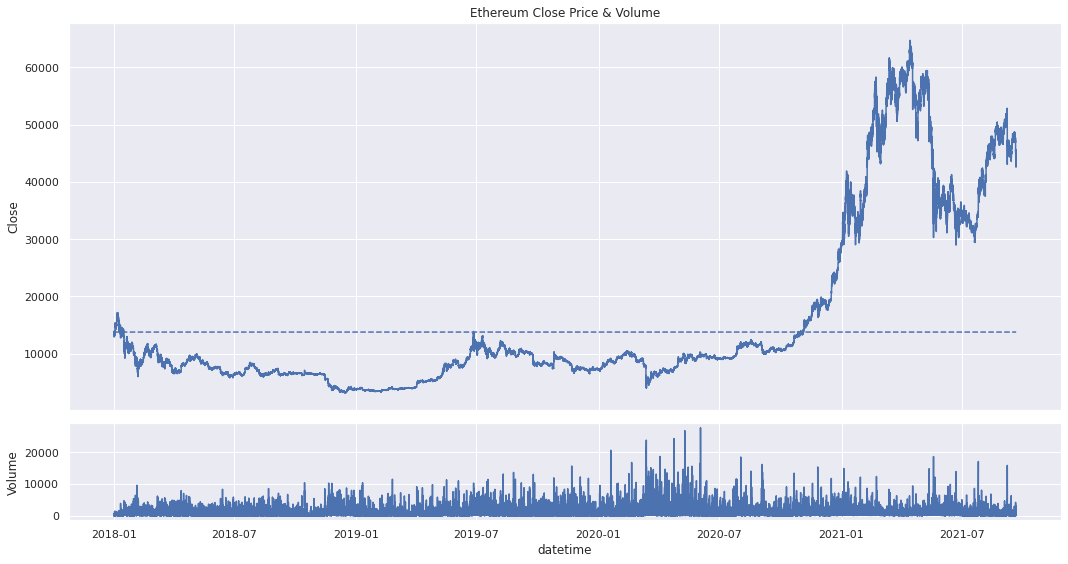

In [12]:
initial_price = np.full(len(df), df['Close'][0])
# specify plot layouts with different width using subplots()
f, axs = plt.subplots(2,1,
                      figsize=(15,8),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[2,0.5]))

# make scatterplot with legends
sns.lineplot(data=df,
                x="datetime", y="Close",
                ax=axs[0],
                color='b'
                ).set(title="Ethereum Close Price & Volume")
sns.lineplot(data=df,
                x='datetime',
                y=initial_price,
                ax=axs[0],
                linestyle='dashed',
                color='b')
sns.lineplot(data=df,
                x="datetime",
                y="Volume",
                ax=axs[1],
                legend=False,
                color='b')
f.tight_layout()

In [30]:
rv_1min = pd.DataFrame()
rv_1min["Daily"] = np.sqrt(dataset.realized_variance("Close", "daily"))
rv_1min["Weekly"] = rv_1min["Daily"].rolling(5).mean()
rv_1min["Monthly"] = rv_1min["Daily"].rolling(22).mean()
rv_1min = rv_1min.dropna()

In [36]:
rv_1min = pd.DataFrame()

rv_1min["Daily"] = np.sqrt(dataset.realized_variance("Close", "daily"))
rv_1min["Daily"].rolling(5).mean()


datetime
2018-01-02         NaN
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-06    0.048478
                ...   
2021-09-17    0.022025
2021-09-18    0.021481
2021-09-19    0.016482
2021-09-20    0.030958
2021-09-21    0.029449
Freq: D, Name: Daily, Length: 1359, dtype: float64

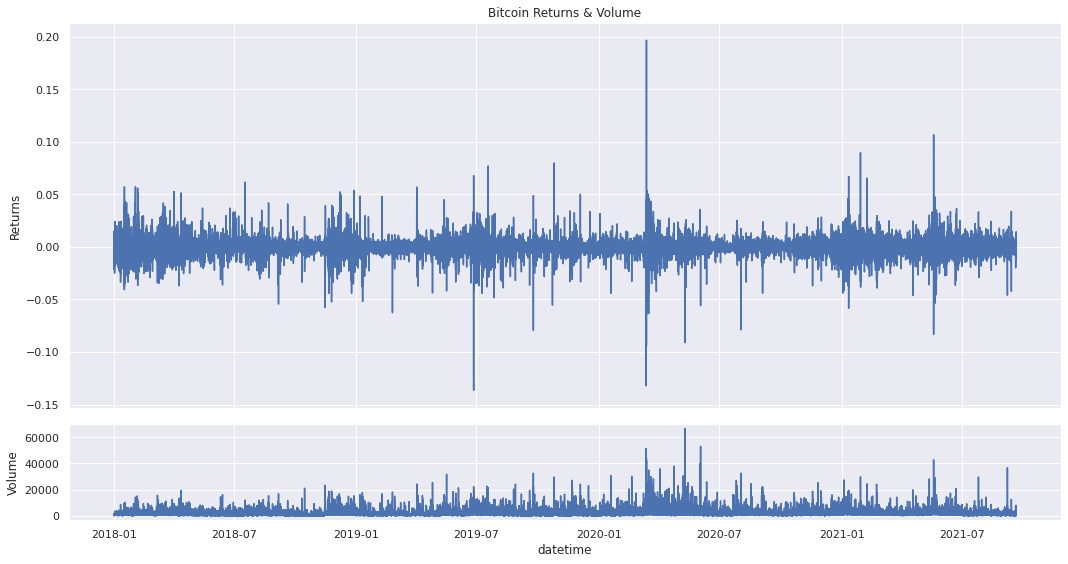

In [35]:
initial_price = np.full(len(df_15), df['Close'][0])
# specify plot layouts with different width using subplots()
f, axs = plt.subplots(2,1,
                      figsize=(15,8),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[2,0.5]))

# make scatterplot with legends
sns.lineplot(data=df_15,
                x="datetime", y="Returns",
                ax=axs[0],
                color='b'
                ).set(title="Bitcoin Returns & Volume")
sns.lineplot(data=df_15,
                x="datetime",
                y="Volume",
                ax=axs[1],
                legend=False,
                color='b')
f.tight_layout()

In [67]:
sns.set_theme(context='notebook', style='whitegrid', palette='Blues', font='serif')


initial_price = np.full(len(df_1d), df['Close'][0])
# specify plot layouts with different width using subplots()
f, axs = plt.subplots(2,1,
                      figsize=(15,8),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[2,0.5]))

# make scatterplot with legends
sns.lineplot(data=df_1d,
                x="datetime", y="Realized Variance",
                ax=axs[0],
                color='b'
                ).set(title="Bitcoin Realized Variance & Volume")
sns.lineplot(data=df_1d,
                x="datetime",
                y="Volume",
                ax=axs[1],
                legend=False,
                color='b')
f.tight_layout()

RuntimeError: latex was not able to process the following string:
b'Bitcoin Realized Variance & Volume'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../785691d2df1dc486cee744e7dadcd096.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-04-10>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 785691d2df1dc486cee744e7dadcd096.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.19 {\rmfamily Bitcoin Realized Variance &
                                            Volume}
No pages of output.
Transcript written on 785691d2df1dc486cee744e7dadcd096.log.




RuntimeError: latex was not able to process the following string:
b'Bitcoin Realized Variance & Volume'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022/Arch Linux) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../785691d2df1dc486cee744e7dadcd096.tex
LaTeX2e <2021-11-15> patch level 1
L3 programming layer <2022-04-10>
(/usr/share/texmf-dist/tex/latex/base/article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(/usr/share/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/share/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 785691d2df1dc486cee744e7dadcd096.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.19 {\rmfamily Bitcoin Realized Variance &
                                            Volume}
No pages of output.
Transcript written on 785691d2df1dc486cee744e7dadcd096.log.




<Figure size 1080x576 with 2 Axes>

In [32]:
rv_1min

,Daily,Weekly,Monthly
datetime,,,
2018-01-23,0.002914,0.061682,0.054155
2018-01-24,0.050232,0.065217,0.052198
2018-01-25,0.019492,0.048380,0.052000
2018-01-26,0.006349,0.029095,0.052130
2018-01-27,0.029682,0.021734,0.048391
...,...,...,...
2021-09-17,0.009764,0.022025,0.023594
2021-09-18,0.021163,0.021481,0.022445
2021-09-19,0.022265,0.016482,0.023306


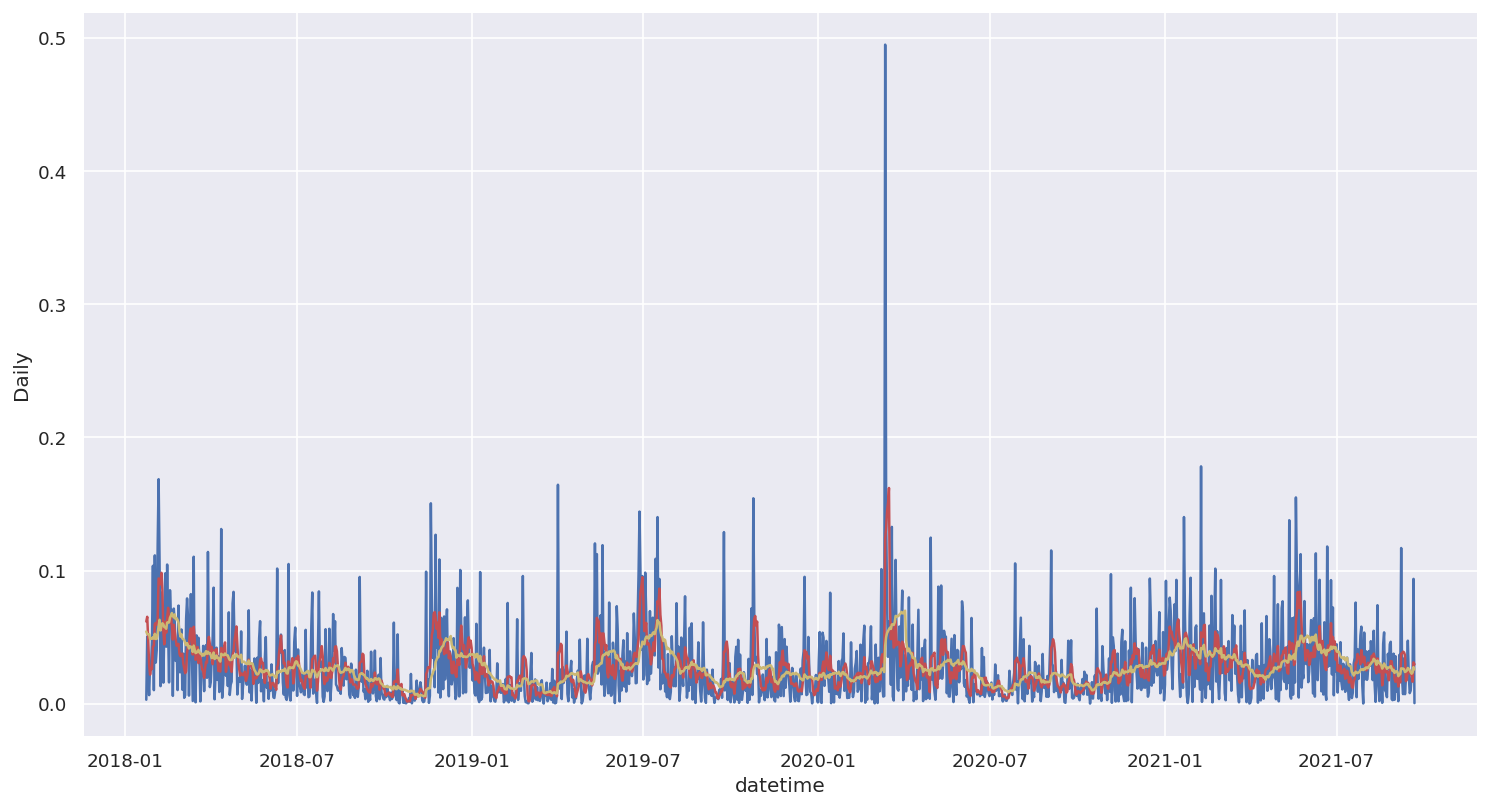

In [33]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=rv_1min, x="datetime", y="Daily", color="b")
sns.lineplot(data=rv_1min, x="datetime", y="Weekly", color="r")
sns.lineplot(data=rv_1min, x="datetime", y="Monthly", color="y")
plt.show()

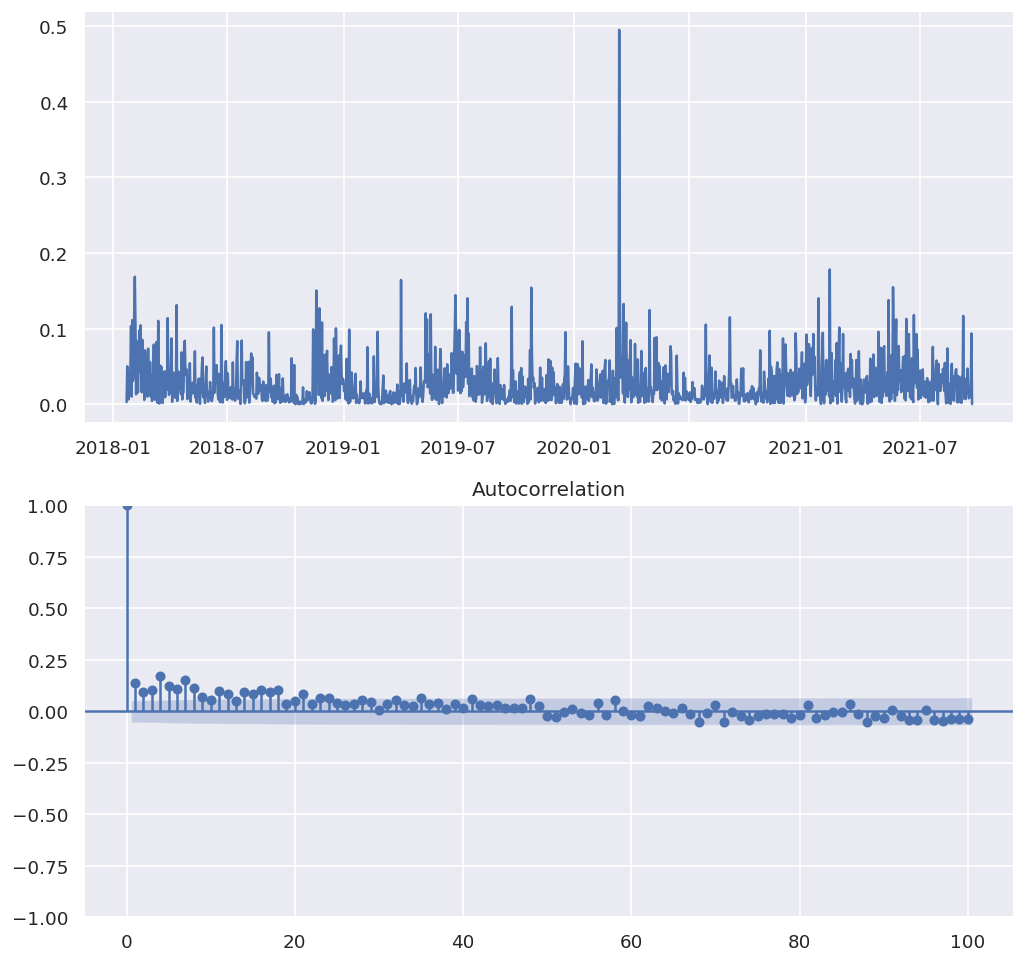

In [34]:
plt.rcParams.update({'figure.figsize':(10,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(2)
axes[0].plot(rv_1min["Daily"])
axes[1].set_title('Original Series')
plot_acf(rv_1min["Daily"], ax=axes[1], lags=100)

plt.show()

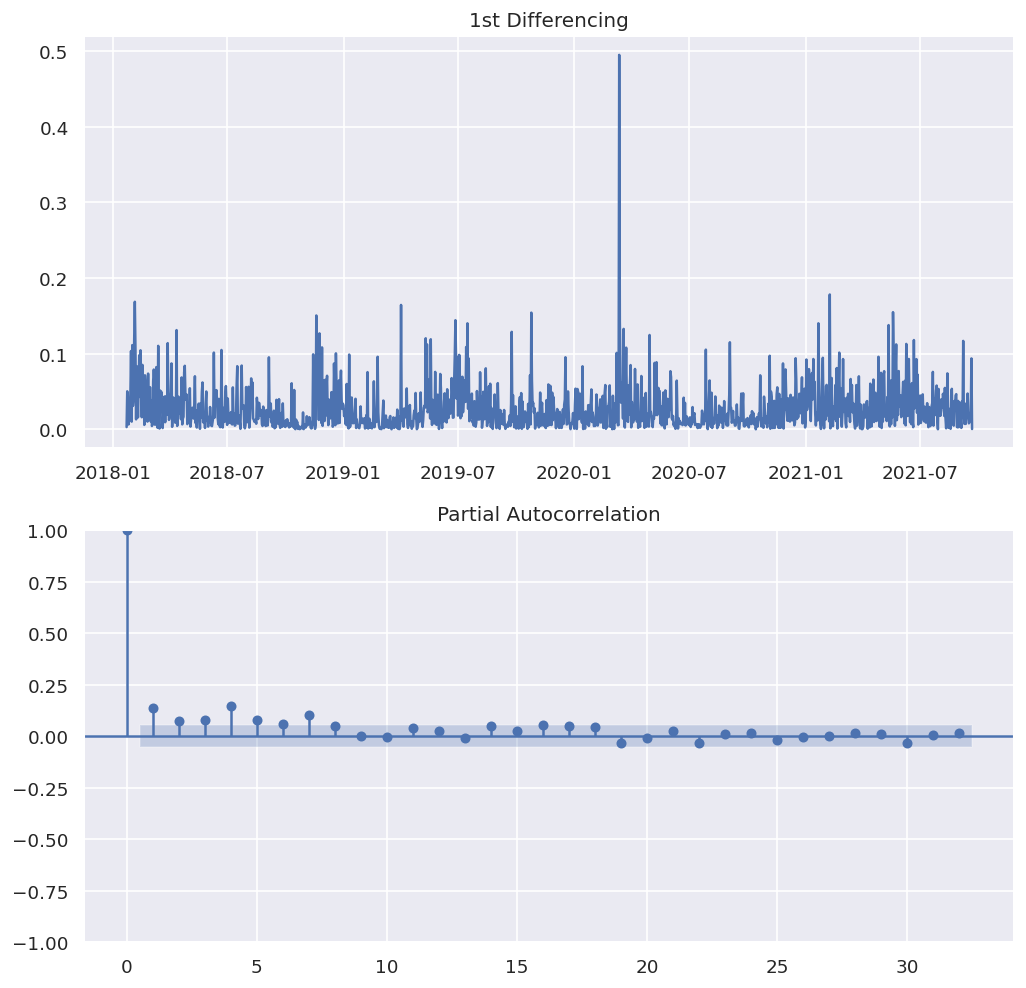

In [35]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(10, 10), 'figure.dpi':120})

fig, axes = plt.subplots(2)
axes[0].plot(rv_1min["Daily"]); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(rv_1min["Daily"].dropna(), ax=axes[1], method="ywm")

plt.show()

## Assumptions

This section is devoted to testing the assumptions on the input data for linear regressions and multilevel linear regressions.

In [36]:
def variance(series):
    return np.sum(np.square(series - np.mean(series))) / series.shape[0]

[Text(0.5, 1.0, 'Ethereum Realized Volatility & Volume')]

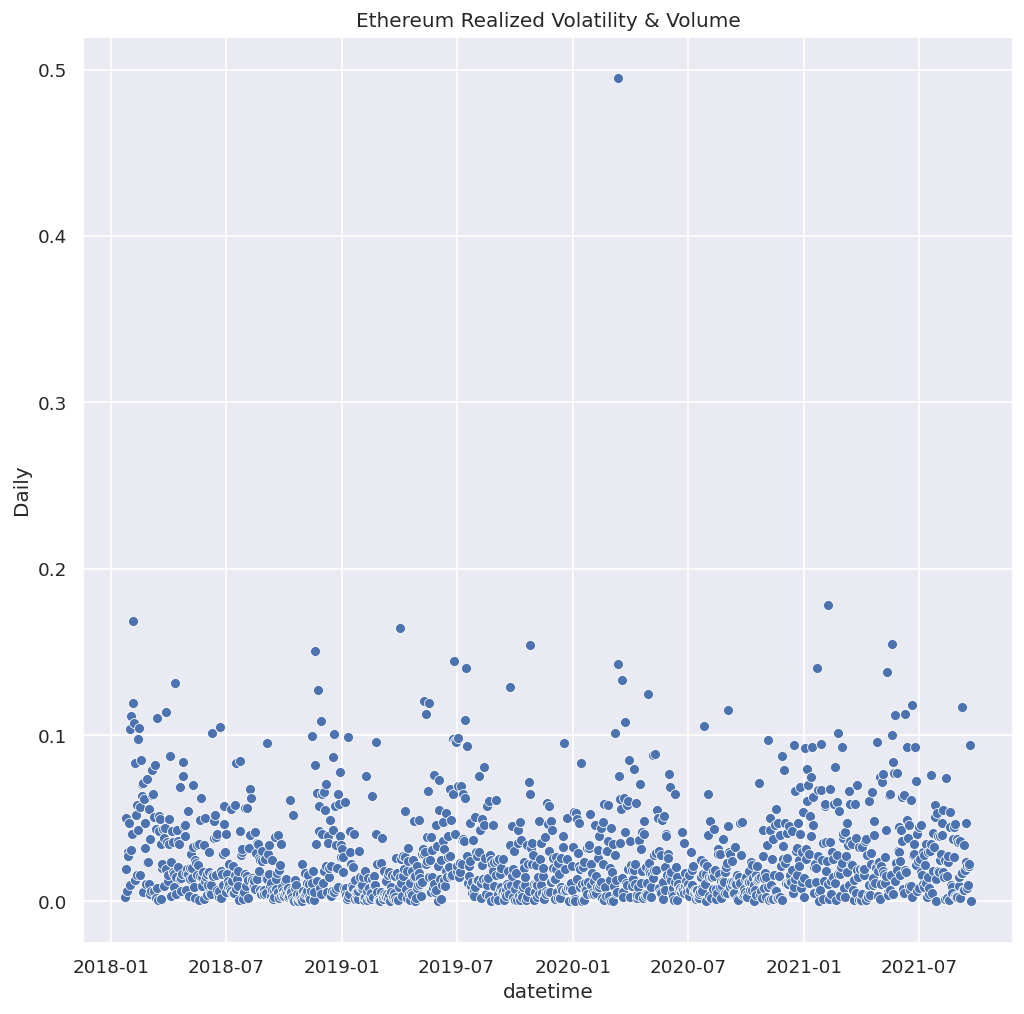

In [37]:
sns.scatterplot(x=rv_1min.index,
             y=rv_1min['Daily'],
             color='b'
             ).set(title="Ethereum Realized Volatility & Volume")

In [38]:
adf = adfuller(rv_1min["Daily"])
print(f"The test statistic of the Augmented Dickey-Fuller test is: {adf[0]}")
print(f"The p-value of the Augmented Dickey-Fuller test is: {adf[1]}")

The test statistic of the Augmented Dickey-Fuller test is: -5.593502612170502
The p-value of the Augmented Dickey-Fuller test is: 1.3128141072051492e-06


## Modeling

### HAR

The Heterogeneous Autoregression model of Corsi (2009) is a simple and empirically useful specification for realized volatility.
It takes the form:

$$RV_t = \beta_0 + \beta_1 RV_{t-1} + \beta_2 RV_{t-1 |t-5} + \beta_3 RV_{t-1|t-22} + u_t$$
where $RV_{t-j|t-h} = \frac{1}{h}\sum_{i=j}^{h} RV_{t-i}$.

This model is developed on ordinary stock returns and thus the 5 day difference in $\beta_2$ is accounting for a trading week and the 22 day difference in $\beta_3$ is accounting for a trading month.
Since cryptocurrencies trade at all times, the periods are adapted to be 7 days and 28 days.

In [39]:
y = rv_1min['Daily'][1:].reset_index(drop=True)
X = rv_1min.iloc[:-1, :].reset_index(drop=True)
dates = y.index
X = sm.add_constant(X)

train_test_split = int(0.66 * X.shape[0])

X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]

In [40]:
X_train

,const,Daily,Weekly,Monthly
0,1.0,0.002914,0.061682,0.054155
1,1.0,0.050232,0.065217,0.052198
2,1.0,0.019492,0.048380,0.052000
3,1.0,0.006349,0.029095,0.052130
4,1.0,0.029682,0.021734,0.048391
...,...,...,...,...
877,1.0,0.008307,0.010019,0.021187
878,1.0,0.008206,0.008723,0.019764
879,1.0,0.005532,0.007886,0.019288
880,1.0,0.007155,0.007208,0.018321


In [41]:
y_train

0      0.050232
1      0.019492
2      0.006349
3      0.029682
4      0.027073
         ...   
877    0.008206
878    0.005532
879    0.007155
880    0.041777
881    0.006580
Name: Daily, Length: 882, dtype: float64

In [42]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     24.60
Date:                Mon, 09 May 2022   Prob (F-statistic):           2.75e-15
Time:                        16:30:28   Log-Likelihood:                 1812.3
No. Observations:                 882   AIC:                            -3617.
Df Residuals:                     878   BIC:                            -3597.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.002      3.812      0.000       0.005       0.014
Daily          0.0493      0.039      1.259      0.209      -0.028       0.126
Weekly         0.2236      0.088      2.539      0.011       0.051       0.396
Monthly        0.3705      0.110      3.370      0.001       0.155       0.586
==============================================================================
Omnibus:                      980.384   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           139782.076
Skew:                           5.085   Prob(JB):                         0.00
Kurtosis:                      63.829   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

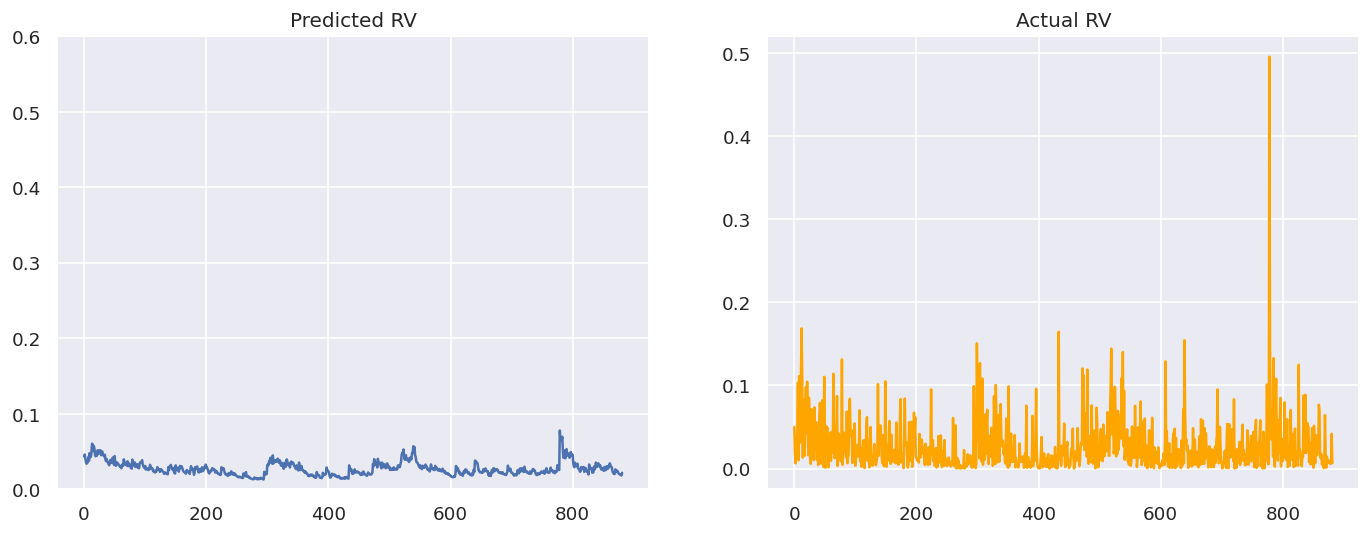

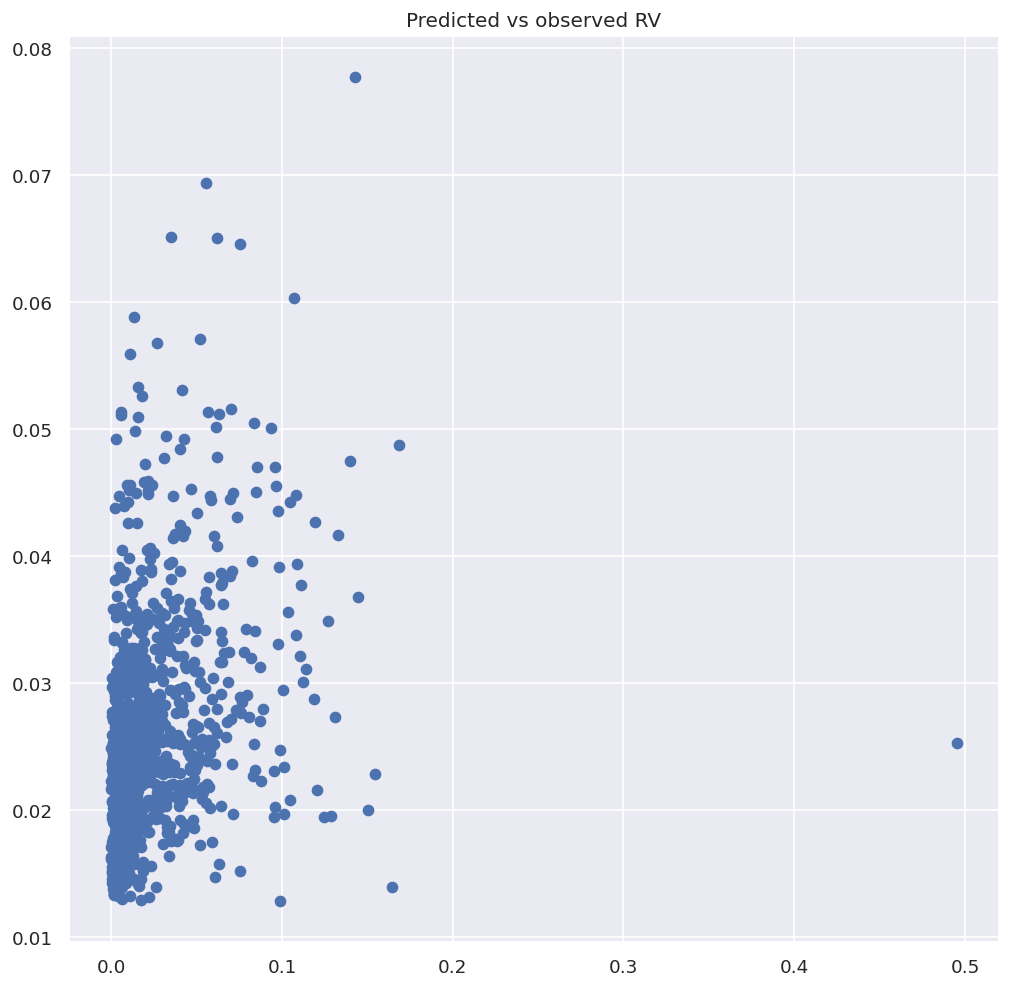

In [43]:

y_hat = results.predict(X_train)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train.index, y_train, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

<AxesSubplot:>

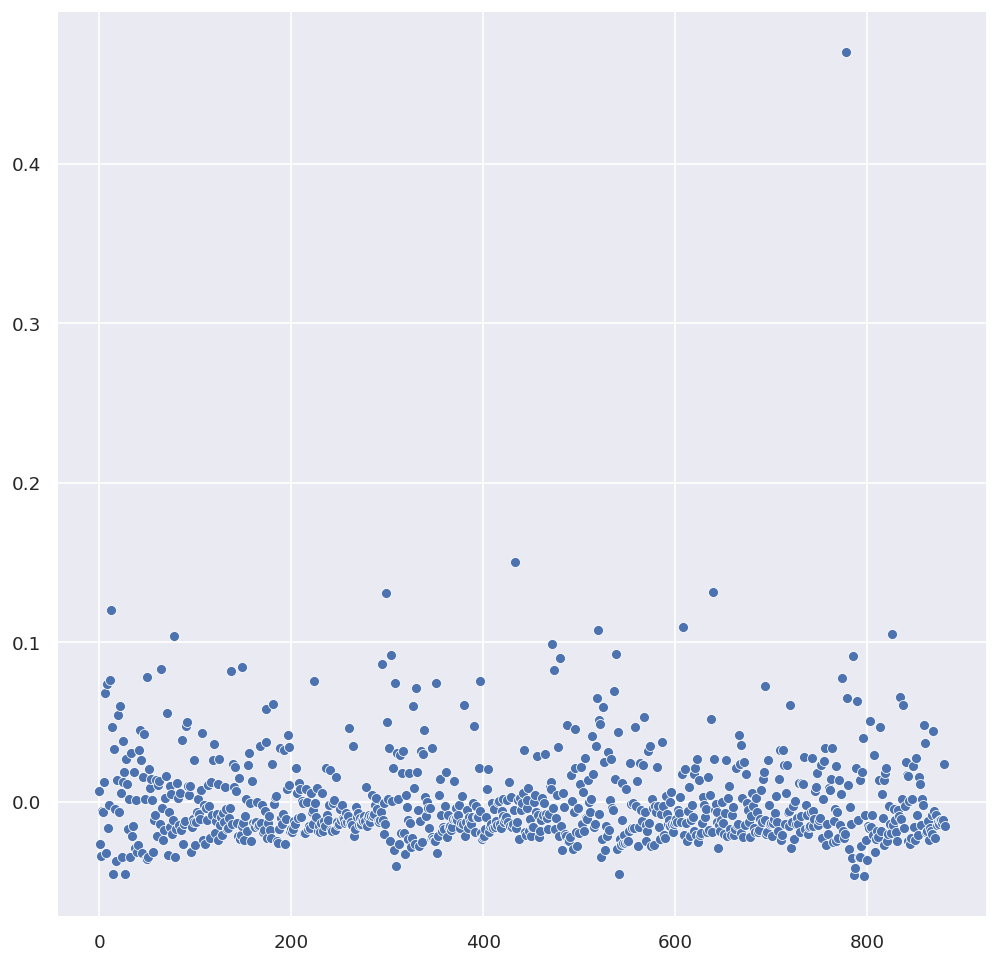

In [44]:
sns.scatterplot(x=results.resid.index, y=results.resid.values)

<AxesSubplot:xlabel='Daily'>

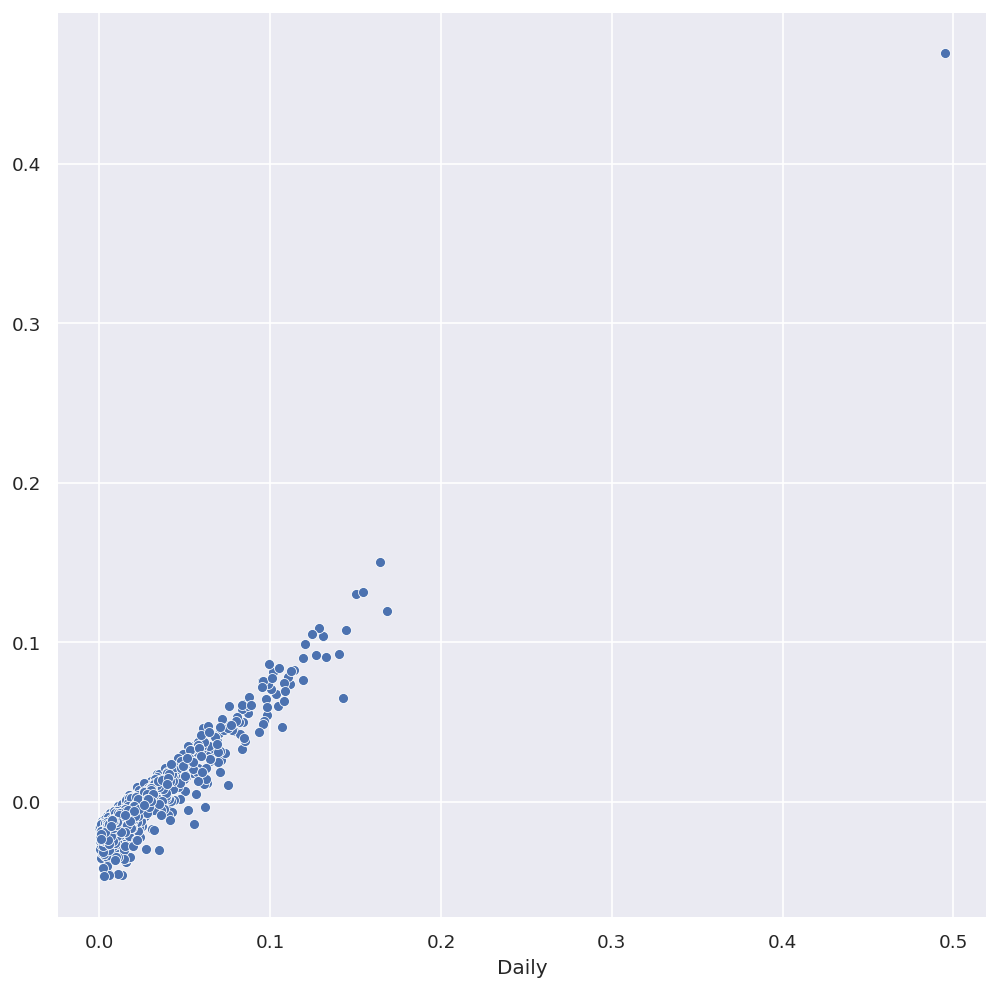

In [45]:
sns.scatterplot(x=y_train, y=results.resid.values)

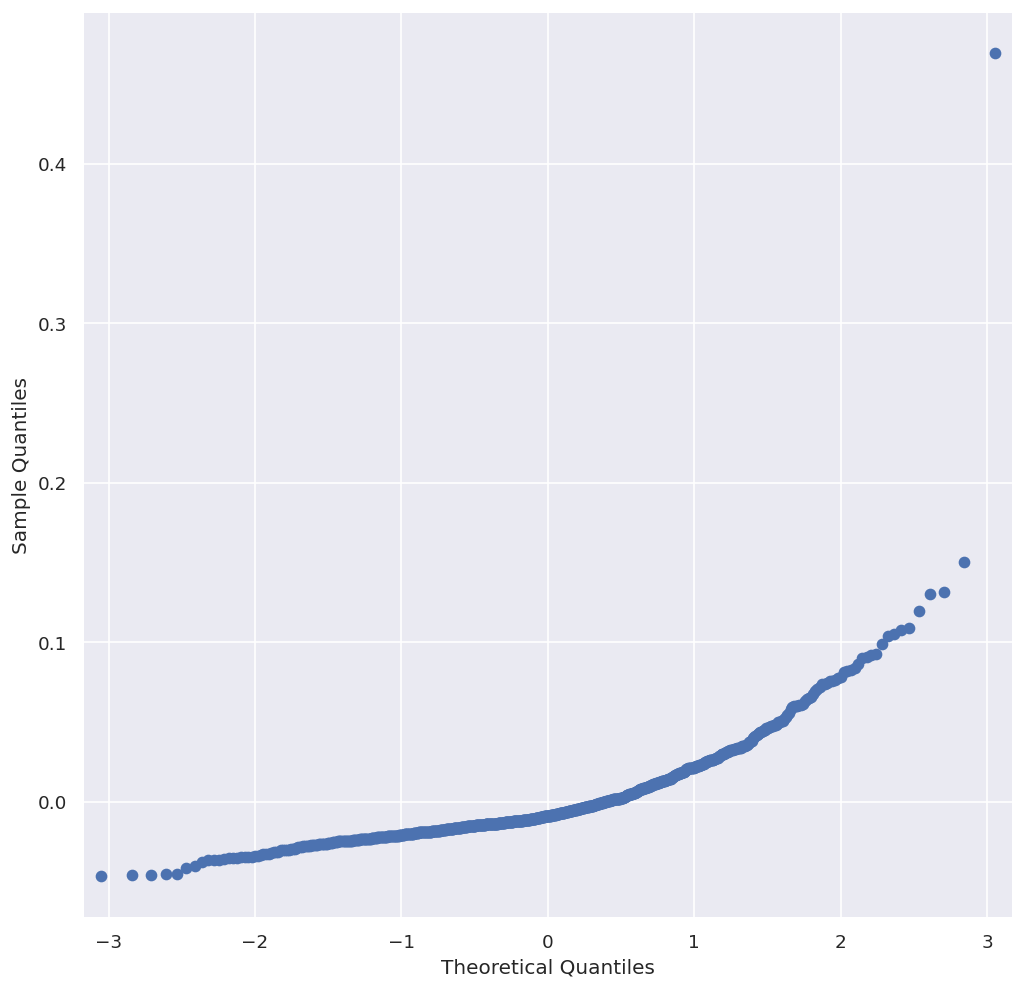

In [46]:
>>> fig = sm.qqplot(results.resid.values)


### HARQ-F

The HARQ is developed to account for the properties of the measurement error in modeling and forecasting volatility.
Exploits the fact that the error in standard realized measures is hetereoskedastic.
On days where the measurement error is small, realized volatility provides a stronger signal for the next day's volatility than on days where it is large.
The HARQ models allow for time-varying autoregressive parameters which are high when variance is low, and adjusted downwared on days when the signal is weak.
These models can be estimated by OLS.
It is shown that the HARQ allows for more persistence in "normal times" and quick mean reversion in erratic times.

The HARQ model is written as:
$$RV_t = \beta_0 + (\beta_1 + \beta_{1Q}RQ_{t-1}^{1/2})RV_{t-1} + \beta_2 RV_{t-1 |t-5} + \beta_3 RV_{t-1|t-22} + u_t$$
where the realized quartercity (RQ) is defined as $RQ_t=\frac{M}{3}\sum_{i=1}^M r^4_{t,i}$.

If we rewrite the HARQ model we are able to estimate the parameters of the model using OLS regression:
$$RV_t = \beta0 + \beta1 RV_{t-1} + \beta_{1Q}RQ^{1/2}_{t-1}RV_{t-1} + \beta_2 RV_{t-1|t-5} 0 \beta_3 RV_{t-1|t-22} + u_t$$

In [70]:
def realized_quarticity(series):
    return np.sum(series**4)*series.shape[0]/3

In [71]:
y = rv_1min['Daily'][1:].reset_index(drop=True)
X = rv_1min.iloc[:-1, :].reset_index(drop=True)


In [72]:
X['RQ1RV1'] = np.sqrt(realized_quarticity(X['Daily'])) * X['Daily']
X['RQ2RV2'] = np.sqrt(realized_quarticity(X['Weekly'])) * X['Weekly']
X['RQ3RV3'] = np.sqrt(realized_quarticity(X['Monthly'])) * X['Monthly']
X = X.reindex(columns=["Daily", "RQ1RV1", "Weekly", "RQ2RV2", "Monthly", "RQ2RV2"])

In [73]:
dates = y.index
X = sm.add_constant(X)

train_test_split = int(0.66 * X.shape[0])

X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]

In [74]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     24.60
Date:                Mon, 09 May 2022   Prob (F-statistic):           2.75e-15
Time:                        16:31:15   Log-Likelihood:                 1812.3
No. Observations:                 882   AIC:                            -3617.
Df Residuals:                     878   BIC:                            -3597.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0094      0.002      3.812      0.000       0.005       0.014
Daily          0.0014      0.001      1.259      0.209      -0.001       0.004
RQ1RV1         0.0082      0.006      1.259      0.209      -0.005       0.021
Weekly         0.0402      0.016      2.539      0.011       0.009       0.071
RQ2RV2         0.0607      0.024      2.539      0.011       0.014       0.108
Monthly        0.3705      0.110      3.370      0.001       0.155       0.586
RQ2RV2         0.0607      0.024      2.539      0.011       0.014       0.108
==============================================================================
Omnibus:                      980.384   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           139782.076
Skew:                           5.085   Prob(JB):                         0.00
Kurtosis:                      63.829   Cond. No.                     2.04e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.18e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

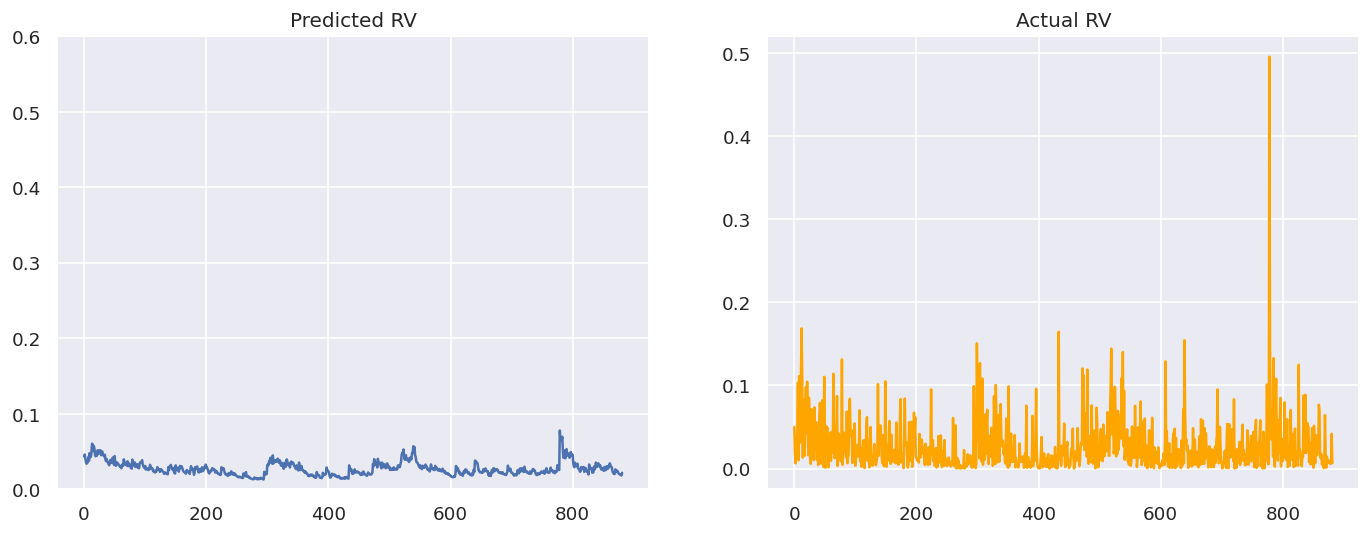

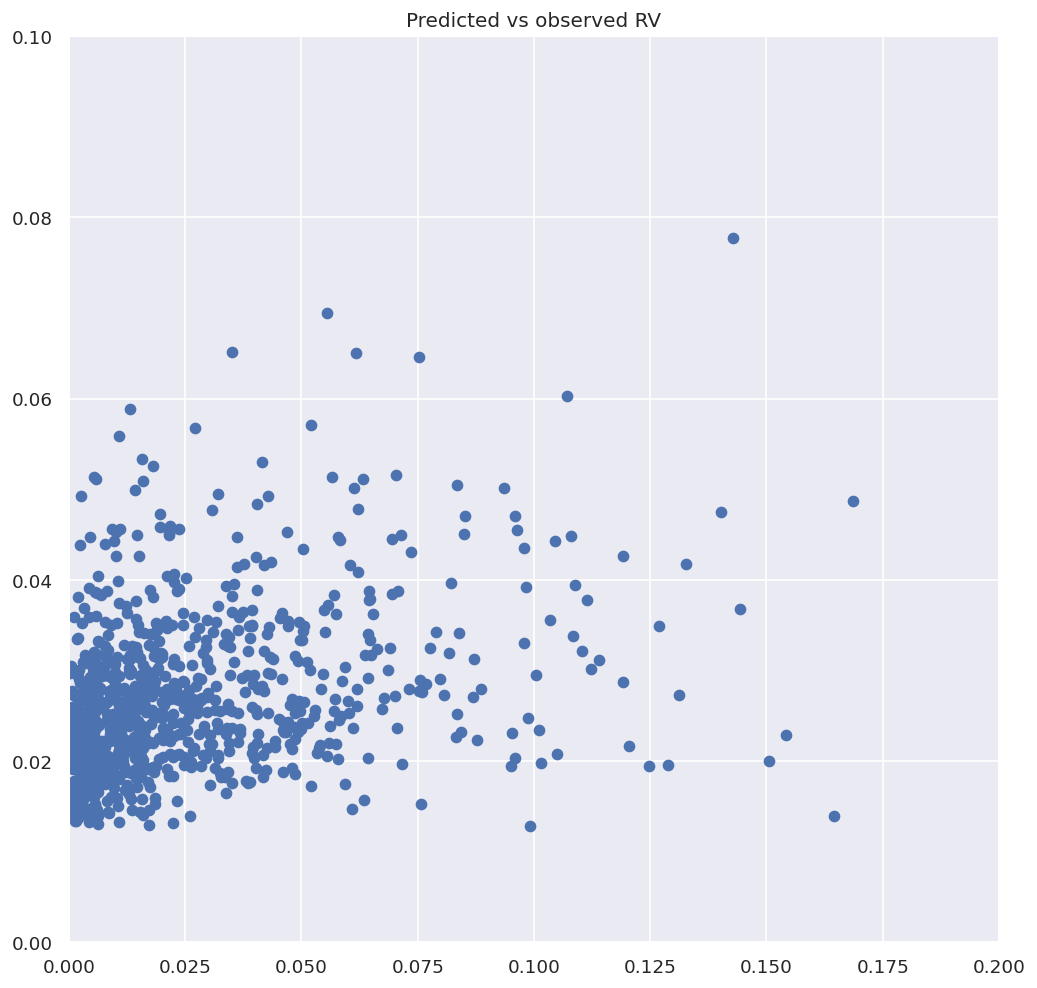

In [75]:

y_hat = results.predict(X_train)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train.index, y_train, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train, y_hat)
plt.title("Predicted vs observed RV")
plt.ylim([0, 0.1])
plt.xlim([0, 0.2])

plt.show()

### HAR-J

The above HAR models does not take jump processes into account.
Therefore, Andersen et al. (2007) developed the HAR-J model denoted as:
$$R_{t+h} = \beta_0 + \beta_d RV_t^{(1)} + \beta_w RV_t^{5} + \beta_m RV_t^{22} + \beta^j J_t + e_{t+h}$$
where the empirical measurement of the squared jumps is $J_t = max(RV_t - BPV_t, 0)$ and the standardized realized bipower variation (BPV) is defined as:
$$BPV_t \equiv (2 / \pi)^{-1} \sum_{j=2}^M |r_{t,j-1}||r_{t,j}|$$

In [53]:
def bipower_variation(series):
    return [(1/(2/np.pi)) * np.sum(np.abs(series[i+1]) - np.abs(series[i])) for i in range(series.shape[0] - 1)]

In [54]:
def squared_jumps(series):
    bpv = bipower_variation(series)
    return [np.maximum(series[i + 1] - bpv[i], 0) for i in range(len(series) - 1)]

In [55]:
X_harj = rv_1min[1:]
jumps = squared_jumps(X_harj['Daily'])[:-1]
X_harj = X_harj[1:-1]
X_harj["Jumps"] = jumps
X_harj = X_harj.reset_index(drop=True)
X_harj

,Daily,Weekly,Monthly,Jumps
0,0.019492,0.048380,0.052000,0.067777
1,0.006349,0.029095,0.052130,0.026994
2,0.029682,0.021734,0.048391,0.000000
3,0.027073,0.026566,0.049175,0.031172
4,0.047175,0.025954,0.048697,0.015599
...,...,...,...,...
1330,0.007887,0.023873,0.025179,0.029004
1331,0.009764,0.022025,0.023594,0.006815
1332,0.021163,0.021481,0.022445,0.003258
1333,0.022265,0.016482,0.023306,0.020535


In [56]:
y_harj = rv_1min['Daily'][3:].reset_index(drop=True)
y_harj

0       0.006349
1       0.029682
2       0.027073
3       0.047175
4       0.103521
          ...   
1330    0.009764
1331    0.021163
1332    0.022265
1333    0.093711
1334    0.000343
Name: Daily, Length: 1335, dtype: float64

In [57]:
dates = y[1:].index
X_harj = sm.add_constant(X_harj)

train_test_split = int(0.66 * X_harj.shape[0])

X_train_harj, X_test_harj = X_harj[:train_test_split], X_harj[train_test_split:]
y_train_harj, y_test_harj = y_harj[:train_test_split], y_harj[train_test_split:]

In [58]:
X_train_harj

,const,Daily,Weekly,Monthly,Jumps
0,1.0,0.019492,0.048380,0.052000,0.067777
1,1.0,0.006349,0.029095,0.052130,0.026994
2,1.0,0.029682,0.021734,0.048391,0.000000
3,1.0,0.027073,0.026566,0.049175,0.031172
4,1.0,0.047175,0.025954,0.048697,0.015599
...,...,...,...,...,...
876,1.0,0.008206,0.008723,0.019764,0.008365
877,1.0,0.005532,0.007886,0.019288,0.009733
878,1.0,0.007155,0.007208,0.018321,0.004606
879,1.0,0.041777,0.014195,0.019042,0.000000


In [59]:
y_train_harj

0      0.006349
1      0.029682
2      0.027073
3      0.047175
4      0.103521
         ...   
876    0.005532
877    0.007155
878    0.041777
879    0.006580
880    0.035004
Name: Daily, Length: 881, dtype: float64

In [60]:
results = sm.OLS(y_train_harj, X_train_harj).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     18.63
Date:                Mon, 09 May 2022   Prob (F-statistic):           1.05e-14
Time:                        16:30:30   Log-Likelihood:                 1810.4
No. Observations:                 881   AIC:                            -3611.
Df Residuals:                     876   BIC:                            -3587.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.002      3.818      0.000       0.005       0.014
Daily          0.0358      0.042      0.855      0.393      -0.046       0.118
Weekly         0.2695      0.100      2.682      0.007       0.072       0.467
Monthly        0.3665      0.110      3.327      0.001       0.150       0.583
Jumps         -0.0246      0.027     -0.916      0.360      -0.077       0.028
==============================================================================
Omnibus:                      976.641   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           137564.346
Skew:                           5.064   Prob(JB):                         0.00
Kurtosis:                      63.373   Cond. No.                         127.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

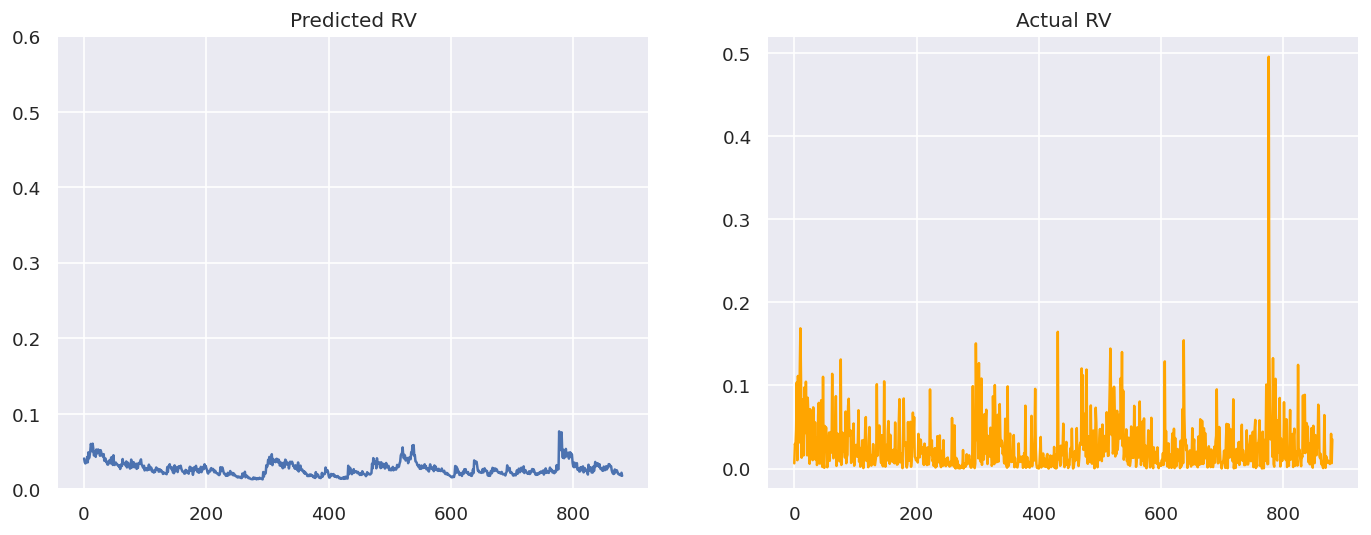

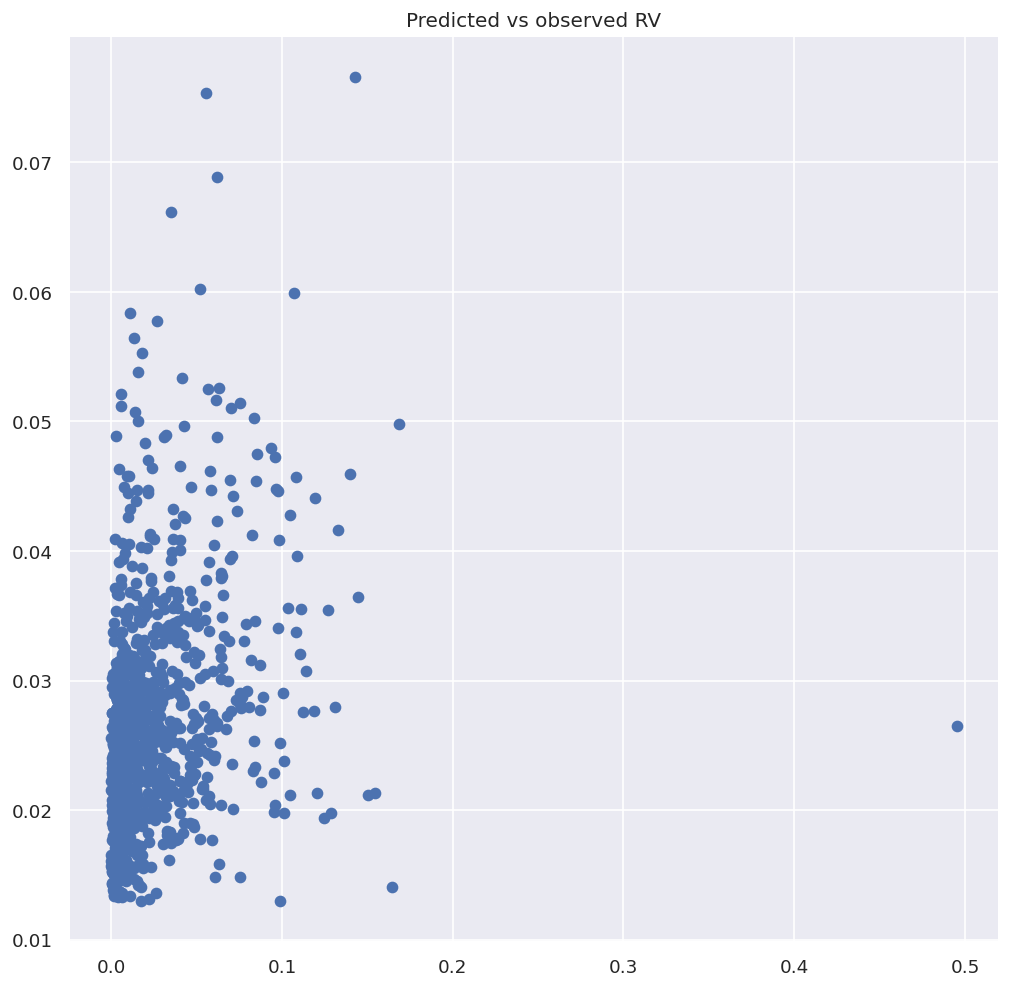

In [61]:
y_hat = results.predict(X_train_harj)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train_harj.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])


#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train_harj.index, y_train_harj, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train_harj, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

### HAR-RS-I

To capture the role of the "leverage effect" in predicting volatility dynamics, Patton and Sheppard developed a group of models using signed realized measures.
The HAR-RS-I model decomposes the daily realized volatility in the standard HAR model into two asymmetric semi-variances: $RS^+_t$ and $R^-_t$:
$$RV_{t+h} = \beta_0 + \beta^+_d RS_t^+ \beta_d^RS_t^- + \beta_w RV_t^{(5)}+\beta_m RV_t^{(22)} + e_{t + h}$$
where $RS^-_t = \sum_{j=1}^M r^2_{t,j} * \mathcal{I}(r_{t,j} < 0)$ and $RS^-_t = \sum_{j=1}^M r^2_{t,j} * \mathcal{I}(r_{t,j} > 0)$.

In [62]:
def realized_semi_variance(series, sign: str):
    if sign == "positive":
        value = [1 if series[i] > 0 else 0 for i in range(len(series))]
    else:
        value = [1 if series[i] < 0 else 0 for i in range(len(series))]
    return value

In [63]:
X_harrsi = rv_1min
X_harrsi
X_harrsi = X_harrsi.merge(dataset.returns("Close", "daily"), left_index=True, right_index=True)
X_harrsi['RV+'] = X_harrsi['Daily'] * realized_semi_variance(X_harrsi['Close'], "positive")
X_harrsi['RV-'] = X_harrsi['Daily'] * realized_semi_variance(X_harrsi['Close'], "negative")
X_harrsi = X_harrsi.drop(columns=["Close", "Daily"])
X_harrsi = X_harrsi[:-1].reset_index(drop=True)

In [64]:
X_harrsi

,Weekly,Monthly,RV+,RV-
0,0.061682,0.054155,0.002914,0.000000
1,0.065217,0.052198,0.050232,0.000000
2,0.048380,0.052000,0.000000,0.019492
3,0.029095,0.052130,0.000000,0.006349
4,0.021734,0.048391,0.029682,0.000000
...,...,...,...,...
1332,0.023873,0.025179,0.000000,0.007887
1333,0.022025,0.023594,0.000000,0.009764
1334,0.021481,0.022445,0.021163,0.000000
1335,0.016482,0.023306,0.000000,0.022265


In [65]:
y_harrsi = rv_1min['Daily'][1:].reset_index(drop=True)
y_harrsi

0       0.050232
1       0.019492
2       0.006349
3       0.029682
4       0.027073
          ...   
1332    0.009764
1333    0.021163
1334    0.022265
1335    0.093711
1336    0.000343
Name: Daily, Length: 1337, dtype: float64

In [66]:
dates = y_harrsi[1:].index
X_harrsi = sm.add_constant(X_harrsi)

train_test_split = int(0.66 * X_harrsi.shape[0])

X_train_harrsi, X_test_harrsi = X_harrsi[:train_test_split], X_harrsi[train_test_split:]
y_train_harrsi, y_test_harrsi = y_harrsi[:train_test_split], y_harrsi[train_test_split:]

In [67]:
results = sm.OLS(y_train_harrsi, X_train_harrsi).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Daily   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     19.55
Date:                Mon, 09 May 2022   Prob (F-statistic):           1.99e-15
Time:                        16:30:32   Log-Likelihood:                 1814.4
No. Observations:                 882   AIC:                            -3619.
Df Residuals:                     877   BIC:                            -3595.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0095      0.002      3.844      0.000       0.005       0.014
Weekly         0.2304      0.088      2.619      0.009       0.058       0.403
Monthly        0.3772      0.110      3.435      0.001       0.162       0.593
RV+           -0.0186      0.051     -0.363      0.717      -0.119       0.082
RV-            0.0848      0.043      1.982      0.048       0.001       0.169
==============================================================================
Omnibus:                      983.788   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           142348.314
Skew:                           5.111   Prob(JB):                         0.00
Kurtosis:                      64.392   Cond. No.                         123.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

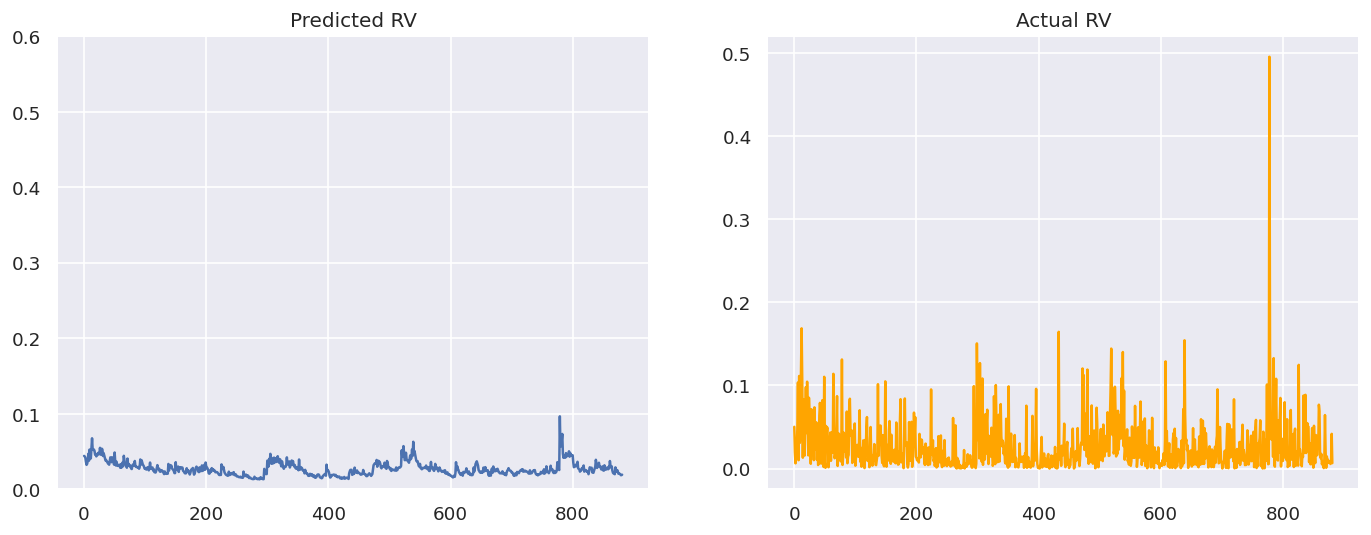

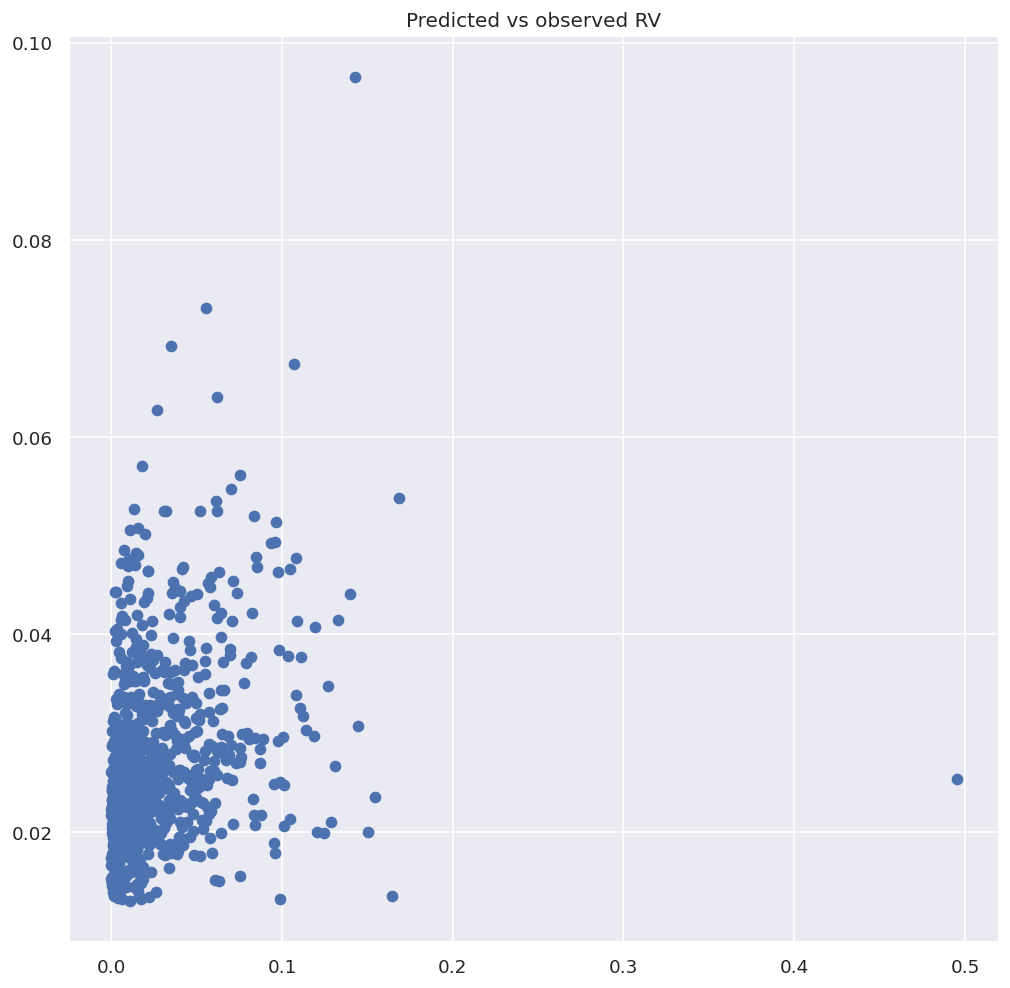

In [68]:
y_hat = results.predict(X_train_harrsi)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_train_harrsi.index, y_hat)
plt.title("Predicted RV")
plt.ylim([0, 0.6])

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_train_harrsi.index, y_train_harrsi, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_train_harrsi, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

### MARS

[Versatile HAR model for realized volatility: A least square
model averaging perspective](https://reader.elsevier.com/reader/sd/pii/S2096232019300046?token=0CCD5C90F3E5F85F534AB8C22C616CCA4CA7405F63A7F603B82831506AD64AD024F6BB5DEC2E090C750D3940EE544A39&originRegion=eu-west-1&originCreation=20220505091619)

### Neural Network Specification of HAR model

A variational autoencoder 

### End-to-End Transformer

## Forecasting Evaluation

In [15]:
def mean_squared_forecast_error(target, predictions):
    pass

In [16]:
def mean_absolute_forecast_error(target, prediction):
    pass

In [ ]:
def mean_squared_deviation_forecase_error(target, prediction):
    pass